# 2026



In [101]:
import pandas as pd
import numpy as np
import os
from itertools import combinations
import re

In [102]:
CONFIG = {
    "k_courses": 2,
    "start_file": "formulario_limpio_1_2026.xlsx",

    "priority_values": {1:150, 2:130, 3:110, 4:100, 5:70, 6:60, 7:50, 8:40, 9:30, 10:20},

    "start_module": {'0820':1,'0940':2,'1100':3,'1220':4,'1450':5,'1610':6,'1730':7,'1850':8,'2010':9},
    "end_module":   {'0930':1,'1050':2,'1210':3,'1330':4,'1600':5,'1720':6,'1840':7,'2000':8,'2120':9},

    "schedule_columns": [
        "Horario Cátedra/Clase",
        "Horario Ayudantía",
        "Horario Taller",
        "Horario Laboratorio"
    ],

    "active_agreement_states": ["Vigente", "Renovación Automática", "Duración indefinida"],
}


In [103]:
def load_data(filename):
    df_students = pd.read_excel(filename, sheet_name="Cursos validados", dtype=str)
    df_courses  = pd.read_excel(filename, sheet_name="Catálogo VRAI", dtype=str)
    #df_convenios = pd.read_excel(filename, sheet_name="Convenios", dtype=str)

    return df_students, df_courses #, df_convenios


def save_output(output_filename, df_success, df_fail, df_combinations):
    with pd.ExcelWriter(output_filename) as writer:
        df_success.to_excel(writer, sheet_name="Con éxito", index=False)
        df_fail.to_excel(writer, sheet_name="Sin éxito", index=False)
        df_combinations.to_excel(writer, sheet_name="Posibles combinaciones", index=False)


def save_next_formulario(next_filename, df_students, df_courses): #, df_convenios):
    with pd.ExcelWriter(next_filename, engine="openpyxl") as writer:
        df_students.to_excel(writer, sheet_name="Cursos validados", index=False)
        df_courses.to_excel(writer, sheet_name="Catálogo VRAI", index=False)
        #df_convenios.to_excel(writer, sheet_name="Convenios", index=False)


In [104]:
def filter_active_convenios(df_convenios, active_states):
    return df_convenios[df_convenios["Estado Actual"].isin(active_states)].copy()


def add_convenio_activo(df_students):
    """
    - convenio activo = True si UA convenio == 'General'
    - o si Unidad Académica == UA convenio
    """
    df = df_students.copy()
    df["convenio activo"] = False

    general_mask = df["UA convenio"].astype(str).str.strip().eq("General")
    match_mask = df["Unidad Académica"].astype(str).str.strip().eq(df["UA convenio"].astype(str).str.strip())

    df.loc[general_mask | match_mask, "convenio activo"] = True
    return df


In [105]:
def find_last_file(prefix, ext=".xlsx"):
    i = 1
    last = None
    while os.path.exists(f"{prefix}_{i}{ext}"):
        last = f"{prefix}_{i}{ext}"
        i += 1
    return last


In [106]:
def parse_schedule(raw):
    return (
        str(raw)
        .strip()
        .replace(" ", "")
        .replace(":", "")
        .replace("\n", "")
        .split(";")
    )


import re

def build_schedule(course_row, schedule_columns, start_module, end_module):
    schedule = {d: [] for d in "LMWJVS"}

    pattern = re.compile(r"([LMWJVS]):(\d{4})\s*a\s*(\d{4})")

    for col in schedule_columns:
        if pd.isna(course_row[col]):
            continue

        text = str(course_row[col])

        # separa TODOS los bloques, sin importar cuántos haya
        for part in text.split(";"):
            part = part.strip()
            if not part:
                continue

            match = pattern.search(part)
            if not match:
                continue

            day, start_time, end_time = match.groups()

            if start_time not in start_module or end_time not in end_module:
                continue

            start = start_module[start_time]
            end = end_module[end_time]

            schedule[day].extend(range(start, end + 1))

    return schedule, str(course_row["Campus"]).strip()


def are_compatible_all(course_rows, schedule_columns, start_module, end_module):
    schedules = []
    campuses = []

    # Construir horarios y campus
    for _, row in course_rows.iterrows():
        sch, camp = build_schedule(row, schedule_columns, start_module, end_module)
        schedules.append(sch)
        campuses.append(camp)

    # Comparar todos los pares de cursos
    for i in range(len(schedules)):
        for j in range(i + 1, len(schedules)):
            campus_i = campuses[i]
            campus_j = campuses[j]

            for d in "LMWJVS":
                mods_i = set(schedules[i][d])
                mods_j = set(schedules[j][d])

                # Choque directo
                if mods_i & mods_j:
                    return False

                # Contiguos con cambio de campus
                if campus_i != campus_j:
                    for m in mods_i:
                        if (m + 1 in mods_j) or (m - 1 in mods_j):
                            return False

    return True



In [107]:
def update_assignment_history(
    previous_file,
    next_file,
    df_new_assignments,
    iteration
):
    # Cargar historial previo si existe
    if os.path.exists(previous_file):
        try:
            df_history = pd.read_excel(
                previous_file,
                sheet_name="Historial asignaciones",
                dtype=str
            )
        except ValueError:
            df_history = pd.DataFrame()
    else:
        df_history = pd.DataFrame()

    # Preparar nuevas filas
    df_new = df_new_assignments.copy()
    df_new["Iteración"] = iteration

    # Append
    df_history = pd.concat([df_history, df_new], ignore_index=True)

    # Escribir al nuevo formulario
    with pd.ExcelWriter(next_file, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        df_history.to_excel(writer, sheet_name="Historial asignaciones", index=False)


In [108]:
def score_combo(student_rows, idxs, priority_values):
    # Mapear Prioridad -> puntaje y sumar
    total = 0
    for i in idxs:
        pr = pd.to_numeric(student_rows.iloc[i]["Prioridad"], errors="coerce")
        if pd.isna(pr):
            return None
        total += priority_values.get(int(pr), 0)
    return total


def generate_best_combos_per_student(
    df_students,
    df_courses,
    k,
    schedule_columns,
    start_module,
    end_module,
    priority_values
):
    """
    Produce:
    - df_combinations: todas las combinaciones compatibles
    - df_best: 1 fila por estudiante con la mejor combinación (mayor Score total)
    """
    all_rows = []
    best_rows = []

    # Solo cursos del catálogo
    df_students = df_students[df_students["Curso dentro del catálogo"] == "Sí"].copy()

    for rut, s in df_students.groupby("RUT UC"):
        s = s.reset_index(drop=True)
        if len(s) < k:
            continue

        best_score = None
        best_combo = None

        for idxs in combinations(range(len(s)), k):
            # Regla: no repetir Sigla en la combinación
            siglas = list(s.loc[list(idxs), "Sigla"].astype(str))
            if len(set(siglas)) != k:
                continue

            nrcs = list(s.loc[list(idxs), "NRC"].astype(str))

            course_rows = df_courses[df_courses["NRC"].astype(str).isin(nrcs)]
            if len(course_rows) != k:
                continue

            if not are_compatible_all(course_rows, schedule_columns, start_module, end_module):
                continue

            sc = score_combo(s, idxs, priority_values)
            if sc is None:
                continue

            row = {
                "RUT UC": rut,
                "Nombre": s.loc[0, "Nombre completo"],
                "Email": s.loc[0, "Correo electrónico2"],
                "Score_total": sc,
            }

            # Guardamos detalle por curso
            for j, i in enumerate(idxs, start=1):
                row[f"Curso {j} - NRC"] = str(s.loc[i, "NRC"])
                row[f"Curso {j} - Sigla"] = str(s.loc[i, "Sigla"])
                row[f"Curso {j} - Unidad Académica"] = str(s.loc[i, "Unidad Académica"])
                row[f"Curso {j} - Prioridad"] = str(s.loc[i, "Prioridad"])
                row[f"Curso {j} - Convenio"] = bool(s.loc[i, "convenio activo"])
                row[f"Curso {j} - ReqGrad"] = str(s.loc[i, "¿Necesitas este curso para la obtención del grado en tu universidad de origen?"])
            all_rows.append(row)

            if best_score is None or sc > best_score:
                best_score = sc
                best_combo = row

        if best_combo is not None:
            best_rows.append(best_combo)

    df_combinations = pd.DataFrame(all_rows)
    df_best = pd.DataFrame(best_rows)
    return df_combinations, df_best


In [109]:
def compute_ideal_demand_priority_only(
    df_students,
    df_courses,
    schedule_columns,
    start_module,
    end_module
):
    """
    Ideal mode:
    - asigna TODOS los cursos posibles a cada estudiante
    - en orden de prioridad
    - sin considerar vacantes
    - solo restricciones técnicas
    """
    demand = {}

    for rut, s in df_students.groupby("RUT UC"):
        s = s.copy()
        s["Prioridad"] = pd.to_numeric(s["Prioridad"], errors="coerce")
        s = s.sort_values("Prioridad")

        accepted_rows = []

        for _, row in s.iterrows():
            nrc = str(row["NRC"])
            course_row = df_courses[df_courses["NRC"].astype(str) == nrc]

            if course_row.empty:
                continue

            # Chequear compatibilidad con lo ya aceptado
            candidate = pd.concat(
                accepted_rows + [course_row],
                ignore_index=True
            )

            if are_compatible_all(
                candidate,
                schedule_columns,
                start_module,
                end_module
            ):
                accepted_rows.append(course_row)
                demand[nrc] = demand.get(nrc, 0) + 1

    return demand



In [110]:
def build_course_demand(df_best, k):
    parts = []
    for i in range(1, k + 1):
        temp = df_best[[
            "RUT UC", "Nombre", "Email",
            f"Curso {i} - NRC",
            f"Curso {i} - Unidad Académica",
            f"Curso {i} - Prioridad",
            f"Curso {i} - Convenio",
            f"Curso {i} - ReqGrad"
        ]].copy()

        temp.columns = [
            "RUT UC", "Nombre", "Email",
            "NRC", "Unidad Académica", "Prioridad", "Convenio", "ReqGrad"
        ]
        temp["Curso_num"] = i
        parts.append(temp)

    return pd.concat(parts, ignore_index=True)


In [111]:
def sort_course_demand_like_original(df_demand):
    """
    Ordenar exactamente como sort_values:
    by=['NRC','Prioridad','Convenio','ReqGrad','random_order']
    ascending=[True, False, False, True, True]
    """
    df = df_demand.copy()

    df["Prioridad"] = pd.to_numeric(df["Prioridad"], errors="coerce")
    df["random_order"] = np.random.rand(len(df))
    
    return df.sort_values(
        by=["NRC", "Prioridad", "Convenio", "ReqGrad", "random_order"],
        ascending=[True, False, False, False, True]
    )


def assign_by_vacancies(df_sorted, df_courses):
    assigned_rows = []
    assigned_count = {}

    vacantes = (
        df_courses.set_index(df_courses["NRC"].astype(str))["Vacantes Ofrecidas Máximas"]
        .to_dict()
    )

    for _, row in df_sorted.iterrows():
        nrc = str(row["NRC"])
        cap = vacantes.get(nrc, np.nan)
        if pd.isna(cap):
            continue

        used = assigned_count.get(nrc, 0)
        if used < cap:
            assigned_count[nrc] = used + 1
            assigned_rows.append(row)

    return pd.DataFrame(assigned_rows)


In [112]:
def split_success_fail(df_assigned, df_students_all, k):
    """
    Éxito: estudiantes con >= k cursos asignados
    Fail: el resto
    """
    if df_assigned.empty:
        # nadie asignado => todos fail
        df_fail = df_students_all[["Nombre completo", "RUT UC"]].drop_duplicates()
        return df_assigned, df_fail

    counts = df_assigned["RUT UC"].value_counts()
    success_ruts = counts[counts >= k].index.tolist()

    df_success = df_assigned[df_assigned["RUT UC"].isin(success_ruts)].copy()

    all_ruts = set(df_students_all["RUT UC"].astype(str).unique())
    success_set = set(map(str, success_ruts))
    fail_ruts = list(all_ruts - success_set)

    df_fail = (
        df_students_all[df_students_all["RUT UC"].astype(str).isin(fail_ruts)]
        [["Nombre completo", "RUT UC"]]
        .drop_duplicates()
        .copy()
    )
    return df_success, df_fail


def update_vacancies(df_courses, df_success):
    df = df_courses.copy()

    usados_por_nrc = df_success["NRC"].astype(str).value_counts()

    def compute(row):
        nrc = str(row["NRC"])
        inicial = row["Vacantes Iniciales"]
        usados = usados_por_nrc.get(nrc, 0)
        restantes = inicial - usados if pd.notna(inicial) else inicial
        return pd.Series({
            "Vacantes Iniciales": inicial,
            "Vacantes Usadas": usados,
            "Vacantes Restantes": restantes,
            "Vacantes Ofrecidas Máximas": restantes
        })

    df[[
        "Vacantes Iniciales",
        "Vacantes Usadas",
        "Vacantes Restantes",
        "Vacantes Ofrecidas Máximas"
    ]] = df.apply(compute, axis=1)

    return df



In [113]:
def run_iterations_real(config):
    iteration = 1
    current_file = config["start_file"]
    k = config["k_courses"]

    while os.path.exists(current_file):
        print(f"\n[REAL] Ejecutando iteración {iteration} | Archivo: {current_file}")

        df_students_raw, df_courses_raw = load_data(current_file)

        df_students = df_students_raw.copy()
        df_students = df_students[df_students["Curso dentro del catálogo"] == "Sí"].copy()
        df_students = add_convenio_activo(df_students)

        df_courses = df_courses_raw.copy()
        df_courses["Vacantes Ofrecidas Máximas"] = pd.to_numeric(
            df_courses["Vacantes Ofrecidas Máximas"], errors="coerce"
        )

        if iteration == 1 or "Vacantes Iniciales" not in df_courses.columns:
            df_courses["Vacantes Iniciales"] = df_courses["Vacantes Ofrecidas Máximas"]
            df_courses["Vacantes Usadas"] = 0
            df_courses["Vacantes Restantes"] = df_courses["Vacantes Ofrecidas Máximas"]

        # combinaciones
        df_combos, df_best = generate_best_combos_per_student(
            df_students=df_students,
            df_courses=df_courses,
            k=k,
            schedule_columns=config["schedule_columns"],
            start_module=config["start_module"],
            end_module=config["end_module"],
            priority_values=config["priority_values"]
        )

        print(f"[REAL] Estudiantes con combinación viable: {df_best['RUT UC'].nunique()}")

        if df_best.empty:
            print("[REAL] No hay combinaciones viables. Fin.")
            break

        df_demand = build_course_demand(df_best, k)
        df_demand = df_demand.merge(
            df_courses[["NRC", "Vacantes Ofrecidas Máximas"]],
            on="NRC",
            how="left"
        )

        df_sorted = sort_course_demand_like_original(df_demand)
        df_assigned = assign_by_vacancies(df_sorted, df_courses)

        df_success, df_fail = split_success_fail(df_assigned, df_students_raw, k)

        print(f"[REAL] Estudiantes con {k} cursos asignados: {df_success['RUT UC'].nunique()}")
        print(f"[REAL] Estudiantes sin éxito: {df_fail['RUT UC'].nunique()}")

        save_output(f"output_{iteration}.xlsx", df_success, df_fail, df_combos)

        if df_success.empty:
            print("[REAL] No hay más asignaciones exitosas.")
            break

        usados_por_nrc = df_success["NRC"].astype(str).value_counts()

        def update_row(row):
            inicial = pd.to_numeric(row["Vacantes Iniciales"], errors="coerce")
            usados_previos = pd.to_numeric(row["Vacantes Usadas"], errors="coerce")
            usados_previos = 0 if pd.isna(usados_previos) else usados_previos
            usados_nuevos = usados_por_nrc.get(str(row["NRC"]), 0)

            usados_total = usados_previos + usados_nuevos
            restantes = inicial - usados_total if pd.notna(inicial) else inicial

            return pd.Series({
                "Vacantes Iniciales": inicial,
                "Vacantes Usadas": usados_total,
                "Vacantes Restantes": restantes,
                "Vacantes Ofrecidas Máximas": restantes
            })

        df_courses[[
            "Vacantes Iniciales",
            "Vacantes Usadas",
            "Vacantes Restantes",
            "Vacantes Ofrecidas Máximas"
        ]] = df_courses.apply(update_row, axis=1)

        fail_ruts = set(df_fail["RUT UC"].astype(str))
        df_students_next = df_students_raw[df_students_raw["RUT UC"].astype(str).isin(fail_ruts)]

        next_file = f"formulario_limpio_{iteration + 1}.xlsx"
        save_next_formulario(next_file, df_students_next, df_courses)

        iteration += 1
        current_file = next_file

    print("\n[REAL] Proceso terminado.")


In [114]:
run_iterations_real(CONFIG)



[REAL] Ejecutando iteración 1 | Archivo: formulario_limpio_1_2026.xlsx
[REAL] Estudiantes con combinación viable: 287
[REAL] Estudiantes con 2 cursos asignados: 207
[REAL] Estudiantes sin éxito: 91

[REAL] Ejecutando iteración 2 | Archivo: formulario_limpio_2.xlsx
[REAL] Estudiantes con combinación viable: 80
[REAL] Estudiantes con 2 cursos asignados: 1
[REAL] Estudiantes sin éxito: 90

[REAL] Ejecutando iteración 3 | Archivo: formulario_limpio_3.xlsx
[REAL] Estudiantes con combinación viable: 79
[REAL] Estudiantes con 2 cursos asignados: 2
[REAL] Estudiantes sin éxito: 88

[REAL] Ejecutando iteración 4 | Archivo: formulario_limpio_4.xlsx
[REAL] Estudiantes con combinación viable: 77
[REAL] Estudiantes con 2 cursos asignados: 0
[REAL] Estudiantes sin éxito: 88
[REAL] No hay más asignaciones exitosas.

[REAL] Proceso terminado.


In [117]:
def run_single_course_fill(config):
    print("\n[REAL – SINGLE] Inicio relleno de vacantes (1 curso)")

    # Detectar último estado de la fase K
    last_output_k = find_last_file("output")
    last_form_k = find_last_file("formulario_limpio")

    if last_output_k is None or last_form_k is None:
        print("[SINGLE] No se encontraron outputs/formularios de fase K.")
        return

    print(f"[SINGLE] Usando {last_output_k}")
    print(f"[SINGLE] Usando {last_form_k}")

    # Cargar cursos ya asignados en fase K
    df_prev = pd.read_excel(last_output_k, sheet_name="Con éxito", dtype=str)

    assigned_history = {
        str(rut): g["NRC"].astype(str).tolist()
        for rut, g in df_prev.groupby("RUT UC")
    }

    iteration = 1
    current_file = last_form_k

    # Iteraciones SINGLE
    while os.path.exists(current_file):
        print(f"\n[SINGLE] Iteración {iteration} | {current_file}")

        df_students_raw, df_courses_raw = load_data(current_file)

        df_students = df_students_raw.copy()
        df_students = df_students[df_students["Curso dentro del catálogo"] == "Sí"].copy()
        df_students = add_convenio_activo(df_students)

        df_courses = df_courses_raw.copy()
        df_courses["Vacantes Ofrecidas Máximas"] = pd.to_numeric(
            df_courses["Vacantes Ofrecidas Máximas"], errors="coerce"
        )

        # Construir demanda (1 curso)
        df_demand = df_students[[
            "RUT UC", "Nombre completo", "Correo electrónico2",
            "NRC", "Unidad Académica", "Prioridad",
            "convenio activo",
            "¿Necesitas este curso para la obtención del grado en tu universidad de origen?"
        ]].copy()

        df_demand.columns = [
            "RUT UC", "Nombre", "Email",
            "NRC", "Unidad Académica", "Prioridad",
            "Convenio", "ReqGrad"
        ]

        df_demand["Prioridad"] = pd.to_numeric(df_demand["Prioridad"], errors="coerce")
        df_demand["random_order"] = np.random.rand(len(df_demand))

        df_sorted = df_demand.sort_values(
            by=["NRC", "Prioridad", "Convenio", "ReqGrad", "random_order"],
            ascending=[True, False, False, True, True]
        )

        # Asignación SINGLE
        asignados = []
        asignados_ruts = set()

        vacantes = (
            df_courses
            .set_index(df_courses["NRC"].astype(str))["Vacantes Ofrecidas Máximas"]
            .to_dict()
        )

        for _, row in df_sorted.iterrows():
            rut = str(row["RUT UC"])
            nrc = str(row["NRC"])

            if rut in asignados_ruts:
                continue

            cupo = vacantes.get(nrc, np.nan)
            if pd.isna(cupo) or cupo < 1:
                continue

            # compatibilidad técnica 
            prev_nrcs = assigned_history.get(rut, [])
            candidate_nrcs = prev_nrcs + [nrc]

            course_rows = df_courses[
                df_courses["NRC"].astype(str).isin(candidate_nrcs)
            ]

            if not are_compatible_all(
                course_rows,
                config["schedule_columns"],
                config["start_module"],
                config["end_module"]
            ):
                continue

            # asignar
            vacantes[nrc] -= 1
            asignados_ruts.add(rut)
            asignados.append(row)

        if not asignados:
            print("[SINGLE] No quedan asignaciones posibles.")
            break

        df_assigned = pd.DataFrame(asignados)
        print(f"[SINGLE] Estudiantes asignados en esta ronda: {df_assigned['RUT UC'].nunique()}")

        # Guardar output SINGLE
        out_name = f"output_single_{iteration}.xlsx"
        with pd.ExcelWriter(out_name) as writer:
            df_assigned.to_excel(writer, sheet_name="Con éxito", index=False)
            df_students_raw[
                ~df_students_raw["RUT UC"].astype(str).isin(asignados_ruts)
            ][["Nombre completo", "RUT UC"]].drop_duplicates().to_excel(
                writer, sheet_name="Sin éxito", index=False
            )

        print(f"[SINGLE] Guardado {out_name}")

        # Actualizar historial y catálogo
        for rut, g in df_assigned.groupby("RUT UC"):
            assigned_history.setdefault(str(rut), [])
            assigned_history[str(rut)].extend(g["NRC"].astype(str).tolist())

        for nrc, used in df_assigned["NRC"].astype(str).value_counts().items():
            df_courses.loc[
                df_courses["NRC"].astype(str) == nrc,
                "Vacantes Ofrecidas Máximas"
            ] -= used

        # Preparar siguiente formulario
        next_file = f"formulario_single_{iteration}.xlsx"
        save_next_formulario(
            next_file,
            df_students_raw[
                ~df_students_raw["RUT UC"].astype(str).isin(asignados_ruts)
            ],
            df_courses
        )

        iteration += 1
        current_file = next_file

    print("\n[REAL – SINGLE] Relleno terminado.")


In [118]:
run_single_course_fill(CONFIG)


[REAL – SINGLE] Inicio relleno de vacantes (1 curso)
[SINGLE] Usando output_4.xlsx
[SINGLE] Usando formulario_limpio_4.xlsx

[SINGLE] Iteración 1 | formulario_limpio_4.xlsx
[SINGLE] Estudiantes asignados en esta ronda: 83
[SINGLE] Guardado output_single_1.xlsx

[SINGLE] Iteración 2 | formulario_single_1.xlsx
[SINGLE] No quedan asignaciones posibles.

[REAL – SINGLE] Relleno terminado.


## Algoritmo (versión REAL): asignación de cursos con vacantes + relleno.

### Contexto de los datos
- **formulario_limpio_1**: Nombre de la data a trabajar, se sigue formato 2025
- **Cursos validados**: cada fila es un *curso solicitado* por un estudiante (múltiples filas por estudiante).
- **Catálogo VRAI**: contiene cursos y sus **Vacantes Ofrecidas Máximas** para los estudiantes de intercambio.
- Solo se consideran solicitudes con **“Curso dentro del catálogo” = Sí**.

---

## Fase A — Asignación principal de K cursos (ej. K=2), de forma iterativa.

### 1) Preparación de estudiantes y cursos
1. Se carga el archivo `formulario_limpio_1.xlsx`.
2. Se filtran solicitudes a las que están en catálogo.
3. Se crea la columna **convenio activo**:
   - `True` si `UA convenio == "General"` o si `Unidad Académica == UA convenio`.
4. Se cargan los cursos del catálogo y se convierten vacantes a número.
5. Se inicializan columnas de tracking de vacantes:
   - **Vacantes Iniciales**, **Vacantes Usadas**, **Vacantes Restantes**.

### 2) Generación de combinaciones por estudiante (K cursos)
Para cada estudiante:
1. Se toman todas sus solicitudes (filas).
2. Se generan todas las combinaciones posibles de tamaño **K**.
3. Se descartan combinaciones que:
   - repiten **Sigla**, o
   - no existan en el catálogo (NRC no encontrado), o
   - tengan conflictos técnicos:
     - choque de módulos,
     - o **cambio de campus en módulos contiguos**.
4. Para cada combinación válida se calcula un **Score** sumando un puntaje por prioridad (mapeo `Prioridad -> puntos`).
5. Se elige la **mejor combinación** (máximo Score) para ese estudiante.
   - Esto define el “deseo óptimo” del estudiante bajo restricciones técnicas (pero aún sin aplicar vacantes).

### 3) Construcción de demanda
1. La mejor combinación de cada estudiante se “explota” a **K filas**, una por curso (NRC).
2. Se hace merge con el catálogo para traer las vacantes actuales del NRC.

### 4) Ordenamiento para repartir vacantes
La demanda se ordena por:
1. **NRC** (agrupa la competencia dentro de cada curso),
2. **Prioridad** (desc),
3. **Convenio** (desc),
4. **ReqGrad** (desc), (Sí/No)
5. **random_order** (asc) como desempate.

> El azar se usa **solo** como desempate dentro del mismo curso y criterio.

### 5) Asignación por vacantes
Se recorre la demanda ordenada:
- para cada fila (un estudiante compitiendo por un NRC),
- se asigna si el NRC todavía tiene vacantes disponibles.
Se guarda el resultado como “filas asignadas”.

### 6) Definición de “éxito” y creación del siguiente formulario
- Un estudiante tiene **éxito** si alcanza **K cursos asignados** en esa ronda.
- Los estudiantes que no llegan a K se mantienen “en competencia” para la siguiente iteración.
- Se crea `formulario_limpio_{i+1}.xlsx` con:
  - solo los estudiantes sin éxito (para reintentar),
  - el catálogo con **vacantes restantes** (y tracking acumulado).

La Fase A se repite hasta que ya no haya asignaciones nuevas.

---

## Fase B — Relleno de vacantes con 1 curso (SINGLE), iterativo

### Objetivo
Usar los cupos que quedan para dar **1 curso adicional** a estudiantes, sin romper restricciones técnicas.

### Cómo funciona
1. Se detecta el último estado de la fase K:
   - último `output_i.xlsx` (para saber qué cursos ya tiene cada estudiante),
   - último `formulario_limpio_i.xlsx` (para partir con las vacantes restantes).
2. En cada iteración SINGLE:
   - se arma demanda con **todas las solicitudes** (1 fila por solicitud),
   - se ordena con el mismo criterio: `NRC, Prioridad, Convenio, ReqGrad, azar`.
3. Se intenta asignar **máximo 1 curso por estudiante** en esa ronda, pero solo si:
   - hay cupo,
   - y el curso es **compatible** con los cursos ya aceptados por el estudiante
     (horario + campus contiguo).
4. Se actualizan vacantes y el historial de cursos aceptados.
5. Se repite hasta que no se pueda asignar a nadie más.

---

## Resultado
- La fase K asegura una asignación “principal” justa y comparable (K cursos).
- La fase SINGLE maximiza el uso de vacantes sobrantes sin romper compatibilidad.
- En cada formulario queda registrada la foto de vacantes (restantes y acumuladas).


# CASO IDEAL

In [119]:
def run_iterations_ideal(config):
    print("\n[IDEAL] Asignación ideal por prioridad")

    df_students_raw, df_courses_raw = load_data(config["start_file"])

    df_students = df_students_raw.copy()
    df_students = df_students[df_students["Curso dentro del catálogo"] == "Sí"].copy()

    df_students["Prioridad"] = pd.to_numeric(
        df_students["Prioridad"], errors="coerce"
    )

    df_students["Cantidad de cursos ha inscribir"] = pd.to_numeric(
        df_students["Cantidad de cursos ha inscribir"], errors="coerce"
    )

    df_courses = df_courses_raw.copy()
    df_courses["Vacantes Iniciales"] = pd.to_numeric(
        df_courses["Vacantes Ofrecidas Máximas"], errors="coerce"
    )

    assigned_rows = []
    resumen = []
    demand = {}

    # Asignación ideal por estudiante
    for rut, s in df_students.groupby("RUT UC"):
        s = s.sort_values("Prioridad")

        max_k = s["Cantidad de cursos ha inscribir"].iloc[0]
        if pd.isna(max_k) or max_k <= 0:
            continue

        max_k = int(max_k)
        accepted_courses = []

        for _, row in s.head(max_k).iterrows():
            course_row = df_courses[
                df_courses["NRC"].astype(str) == str(row["NRC"])
            ]

            if course_row.empty:
                continue

            candidate = pd.concat(
                accepted_courses + [course_row],
                ignore_index=True
            )

            if are_compatible_all(
                candidate,
                config["schedule_columns"],
                config["start_module"],
                config["end_module"]
            ):
                accepted_courses.append(course_row)

                nrc = str(row["NRC"])
                demand[nrc] = demand.get(nrc, 0) + 1

                assigned_rows.append({
                    "RUT UC": rut,
                    "Nombre": row["Nombre completo"],
                    "NRC": nrc,
                    "Prioridad": row["Prioridad"]
                })

        resumen.append({
            "RUT UC": rut,
            "Cursos ideales asignados": len(accepted_courses)
        })

    df_assigned = pd.DataFrame(assigned_rows)
    df_resumen = pd.DataFrame(resumen)

    # Agregar columnas de brecha al catálogo
    df_courses["Demanda ideal"] = (
        df_courses["NRC"].astype(str)
        .map(lambda x: demand.get(x, 0))
    )

    df_courses["Brecha demanda ideal"] = (
        df_courses["Demanda ideal"] - df_courses["Vacantes Iniciales"]
    )

    # Prints útiles
    print(f"[IDEAL] Estudiantes procesados: {df_resumen.shape[0]}")
    print(f"[IDEAL] Total cursos ideales asignados: {df_assigned.shape[0]}")
    print(
        f"[IDEAL] Promedio cursos ideales por estudiante: "
        f"{df_resumen['Cursos ideales asignados'].mean():.2f}"
    )

    # Guardar formulario ideal
    with pd.ExcelWriter("formulario_ideal.xlsx") as writer:
        df_students_raw.to_excel(
            writer, sheet_name="Cursos validados", index=False
        )
        df_courses.to_excel(
            writer, sheet_name="Catálogo VRAI", index=False
        )
        #df_convenios_raw.to_excel(
        #    writer, sheet_name="Convenios", index=False
        #)
        df_assigned.to_excel(
            writer, sheet_name="Asignaciones ideales", index=False
        )
        df_resumen.to_excel(
            writer, sheet_name="Resumen por estudiante", index=False
        )

    print("[IDEAL] Guardado formulario_ideal.xlsx")


In [120]:
run_iterations_ideal(CONFIG)


[IDEAL] Asignación ideal por prioridad
[IDEAL] Estudiantes procesados: 298
[IDEAL] Total cursos ideales asignados: 856
[IDEAL] Promedio cursos ideales por estudiante: 2.87
[IDEAL] Guardado formulario_ideal.xlsx


In [121]:
import pandas as pd
import matplotlib.pyplot as plt

df_cat = pd.read_excel(
    "formulario_ideal.xlsx",
    sheet_name="Catálogo VRAI",
    dtype=str
)

for col in ["Vacantes Iniciales", "Demanda ideal", "Brecha demanda ideal"]:
    df_cat[col] = pd.to_numeric(df_cat[col], errors="coerce").fillna(0)


In [123]:
# Solo cursos con brecha positiva (faltan cupos)
df_brecha = df_cat[df_cat["Brecha demanda ideal"] > 0].copy()

# Top 15 cursos más críticos
top_brecha = (
    df_brecha
    .sort_values("Brecha demanda ideal", ascending=False)
    .head(15)
)

top_brecha[[
    "NRC",
    "Sigla",
    "Nombre curso",
    "Vacantes Iniciales",
    "Demanda ideal",
    "Brecha demanda ideal"
]]


,NRC,Sigla,Nombre curso,Vacantes Iniciales,Demanda ideal,Brecha demanda ideal
116,29304,ICP0154,Para Entender Latinoamer Hoy,10,24,14
490,14093,IHI0211,Chile y America Indigena,5,15,10
498,24958,IHI0519,Músicas Latinoamericanas,5,14,9
416,15309,ESO008,Folklore Chileno,8,14,6
169,23046,COM407,Teoria de las Organizaciones y,1,6,5
162,14037,COM404,Introduccion a la Publicidad,1,6,5
118,33283,ICP0156,Politica y Poder en Chile,10,15,5
203,31900,SUS2001,Sistemas Alimentarios Regenera,1,5,4
414,29860,EST6300,Esteticas del Cine Chileno,1,5,4
161,13984,COM215,Analisis de la Actualidad Inte,2,6,4


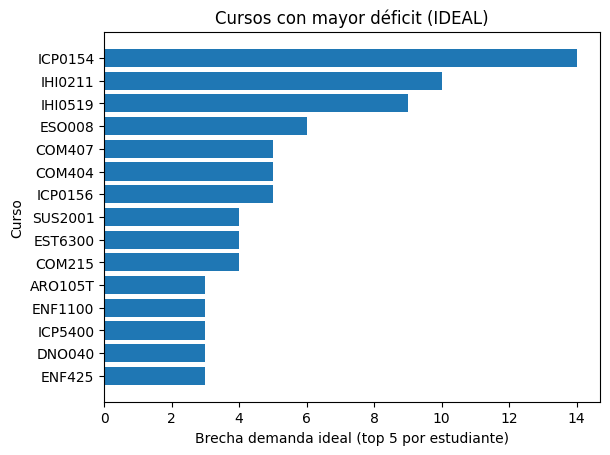

In [124]:
plt.figure()
plt.barh(
    top_brecha["Sigla"],
    top_brecha["Brecha demanda ideal"]
)
plt.xlabel("Brecha demanda ideal (top 5 por estudiante)")
plt.ylabel("Curso")
plt.title("Cursos con mayor déficit (IDEAL)")
plt.gca().invert_yaxis()
plt.show()


In [125]:
print("Cursos con brecha > 0:", (df_cat["Brecha demanda ideal"] > 0).sum())
print("Cursos con brecha > 5:", (df_cat["Brecha demanda ideal"] > 5).sum())
print("Cursos con brecha > 10:", (df_cat["Brecha demanda ideal"] > 10).sum())


Cursos con brecha > 0: 101
Cursos con brecha > 5: 4
Cursos con brecha > 10: 1
